In [86]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload 2

from src.config import DATABASE_PATH, DECISION_TIME_DAYS, TIME_HORIZON_DAYS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cohort Level Modeling

As stated in the previous notebook, we want to build a regressor model $f$ that will predict the ROI in function of time that will work until Horizon H, using only information available until decision time $t_d$:

$$ROI_c(t \leq H) = f(\vec{\theta}(t_d), t) $$

In this model, $\vec{\theta}(t_d)$ are the cohort features, this feature vector is only the parameter set for fitting the ROI curve, and $t$ is, in fact, the dependent variable.

In the below cell, I am loading the cohort features from the database.



In [87]:
from src.features.feature_utils import load_features_from_database

_, cohort_features = load_features_from_database(
    DATABASE_PATH,
    DECISION_TIME_DAYS,
    TIME_HORIZON_DAYS,
    cohort_features=True,
    loan_features=False,
)
cohort_features

Loading cohort features from table: cohort_features_t400_h600


,batch_letter,h_days,ROI,cohort_size,total_loan_amount,avg_loan_amount,median_loan_amount,loan_amount_skewness,avg_interest_rate,median_interest_rate,...,median_days_to_first_repayment,avg_repayment_consistency,pct_loans_totally_repaid,pct_loans_in_billing,pct_loans_normal_repayment,pct_executed,pct_debt_collection,pct_debt_repaid,pct_repaid,avg_loan_amount_x_interest
0,A,1,-0.846597,3183,786691.62,247.154138,50.0,6.007656,3.398743,3.4,...,1.0,0.613675,0.915489,0.014766,0.069746,0.069746,0.014766,0.029532,0.885957,839.168554
1,A,2,-0.618791,3183,786691.62,247.154138,50.0,6.007656,3.398743,3.4,...,1.0,0.613675,0.915489,0.014766,0.069746,0.069746,0.014766,0.029532,0.885957,839.168554
2,A,3,-0.640994,3183,786691.62,247.154138,50.0,6.007656,3.398743,3.4,...,1.0,0.613675,0.915489,0.014766,0.069746,0.069746,0.014766,0.029532,0.885957,839.168554
3,A,4,-0.411533,3183,786691.62,247.154138,50.0,6.007656,3.398743,3.4,...,1.0,0.613675,0.915489,0.014766,0.069746,0.069746,0.014766,0.029532,0.885957,839.168554
4,A,5,-0.389023,3183,786691.62,247.154138,50.0,6.007656,3.398743,3.4,...,1.0,0.613675,0.915489,0.014766,0.069746,0.069746,0.014766,0.029532,0.885957,839.168554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,G,596,-0.007087,14750,3648047.60,247.325261,50.0,9.210035,3.399376,3.4,...,1.0,0.403945,0.889356,0.027458,0.083119,0.083119,0.027458,0.073831,0.815525,840.143094
4196,G,597,-0.007087,14750,3648047.60,247.325261,50.0,9.210035,3.399376,3.4,...,1.0,0.403945,0.889356,0.027458,0.083119,0.083119,0.027458,0.073831,0.815525,840.143094
4197,G,598,-0.007087,14750,3648047.60,247.325261,50.0,9.210035,3.399376,3.4,...,1.0,0.403945,0.889356,0.027458,0.083119,0.083119,0.027458,0.073831,0.815525,840.143094
4198,G,599,-0.007087,14750,3648047.60,247.325261,50.0,9.210035,3.399376,3.4,...,1.0,0.403945,0.889356,0.027458,0.083119,0.083119,0.027458,0.073831,0.815525,840.143094


## Preparing data and packages

In [88]:
# Prepare features and target
train_mask = cohort_features["h_days"] <= DECISION_TIME_DAYS
test_mask = (cohort_features["h_days"] > DECISION_TIME_DAYS) & (cohort_features["h_days"] <= TIME_HORIZON_DAYS)

X = cohort_features.drop(['ROI'], axis=1).copy()
y = cohort_features['ROI'].copy()

X_train = X[train_mask].copy()
y_train = y[train_mask].copy()
X_test = X[test_mask].copy()
y_test = y[test_mask].copy()

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 2800 samples
Test set: 1400 samples


## LightGBM

Starting with a Gradiente Boosting Machine (GBM) regressor model using the LightGBM package. I will use a simple pipeline with a standard scaler and the LGBM regressor. The hyperparameters are set to default values, except for the random state to ensure reproducibility. 

In [89]:
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


numerical_columns_to_scale = [
    col for col in X_train.columns if col not in ["h_days", "batch_letter"]
]

# Create preprocessing pipeline with StandardScaler for all features except h_days
preprocessor = ColumnTransformer(
    transformers=[
        ("h_days", "passthrough", ["h_days"]),  # Keep h_days as-is
        ("batch_letter", "drop", ["batch_letter"]),  # Drop batch_letter
        (
            "scaled",
            StandardScaler(),
            numerical_columns_to_scale,
        ),
    ],
)

# Create the complete pipeline with LGBM
lgbm_pipeline = make_pipeline(preprocessor, LGBMRegressor(random_state=42))

lgbm_pipeline.fit(X=X_train, y=y_train)

,steps,"[('columntransformer', ...), ('lgbmregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('h_days', ...), ('batch_letter', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(-0.8, 0.1192585962371809)

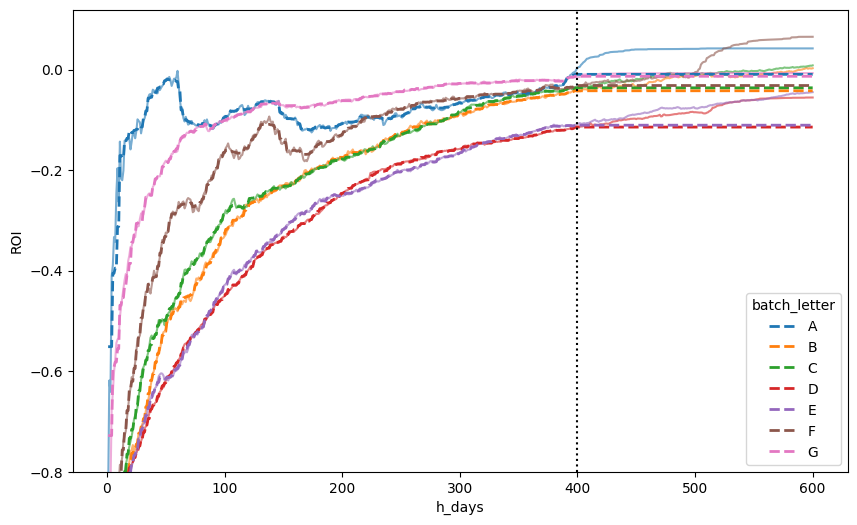

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

cohort_features["predicted_ROI_lgbm"] = lgbm_pipeline.predict(X)

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=cohort_features, x="h_days", y="ROI", hue="batch_letter", legend=False, ax=ax, alpha=0.6)
ax = sns.lineplot(data=cohort_features, x="h_days", y="predicted_ROI_lgbm", hue="batch_letter", linestyle="--", ax=ax, lw=2)
ax.axvline(DECISION_TIME_DAYS, color='black', linestyle=':', label='Decision Time')
ax.set_ylim(-0.8, None)

Clearly the model is overfitting, lets run a grid search in the next cells to find better hyperparameters.

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import PredefinedSplit, GridSearchCV


X_train2 = X_train[X_train["h_days"] <= 0.7 * DECISION_TIME_DAYS].copy()
X_val = X_train[~X_train.index.isin(X_train2.index)].copy()

y_train2 = y_train[X_train2.index]
y_val = y_train[~y_train.index.isin(y_train2.index)]

X_all = pd.concat([X_train2, X_val])
y_all = np.concatenate([y_train2, y_val])

# Mark folds: -1 = training, 0 = validation
test_fold = np.concatenate([
    -1 * np.ones(len(X_train2), dtype=int),
     0 * np.ones(len(X_val), dtype=int)
])

ps = PredefinedSplit(test_fold)


param_grid = {
    "lgbmregressor__n_estimators": [50, 100, 150],
    "lgbmregressor__max_depth": [3, 4, 5],
    "lgbmregressor__learning_rate": [0.05, 0.1, 0.15],
    "lgbmregressor__num_leaves": [10, 15, 20],
}


# Perform grid search with 3-fold cross-validation
grid_search_lgbm = GridSearchCV(
    lgbm_pipeline,
    param_grid,
    cv=ps,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

grid_search_lgbm.fit(X_train, y_train)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lgbmregressor__learning_rate': [0.05, 0.1, ...], 'lgbmregressor__max_depth': [3, 4, ...], 'lgbmregressor__n_estimators': [50, 100, ...], 'lgbmregressor__num_leaves': [10, 15, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,"PredefinedSpl...hape=(2800,)))"
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('h_days', ...), ('batch_letter', ...), ...]"


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(-0.8, 0.11838780122095796)

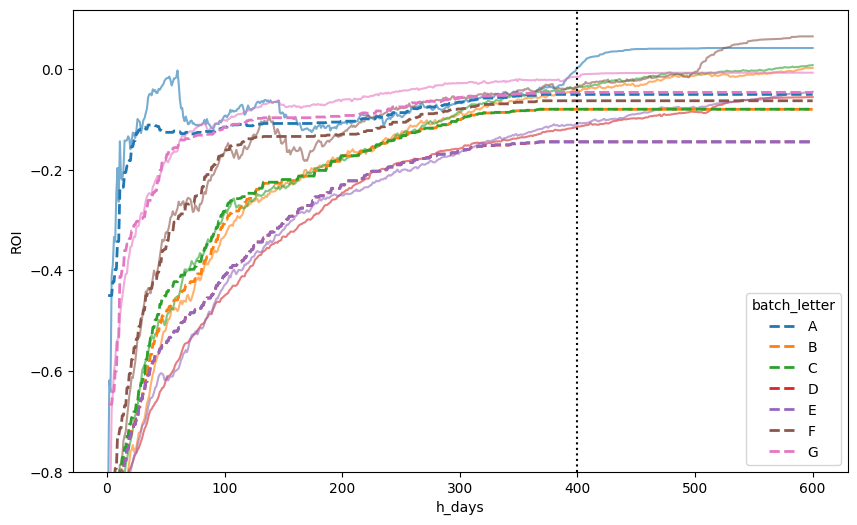

In [106]:
cohort_features["predicted_ROI_lgbm_tuned"] = grid_search_lgbm.best_estimator_.predict(X)

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=cohort_features, x="h_days", y="ROI", hue="batch_letter", legend=False, ax=ax, alpha=0.6)
ax = sns.lineplot(data=cohort_features, x="h_days", y="predicted_ROI_lgbm_tuned", hue="batch_letter", linestyle="--", ax=ax, lw=2)
ax.axvline(DECISION_TIME_DAYS, color='black', linestyle=':', label='Decision Time')
ax.set_ylim(-0.8, None)

Even though the model is overfitting and not following the trend, which is a bad sign. This shows a limitation of tree based models of extrapolating outside the training data range.
Lets compute the final metrics.

In [107]:
from sklearn.metrics import mean_squared_error, r2_score

y_test_pred = grid_search_lgbm.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

Test MSE: 0.0050
Test R²: -1.5101


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


The low R2 comproves the model is not good.

# Trend + Residuals Modeling

Now let's try a different approach based on the failure of the previous model.

Linear models are good to extrapolate trends. The idea is to first fit a trend model using Linear SVM, and then fit a model for the residuals using LGBM.

Before fitting the linear model, I will transform the target variable (ROI) using a box cox transformation to make it as linear as possible (log is not enought in this case, I tried), which is a requirement for linear models.

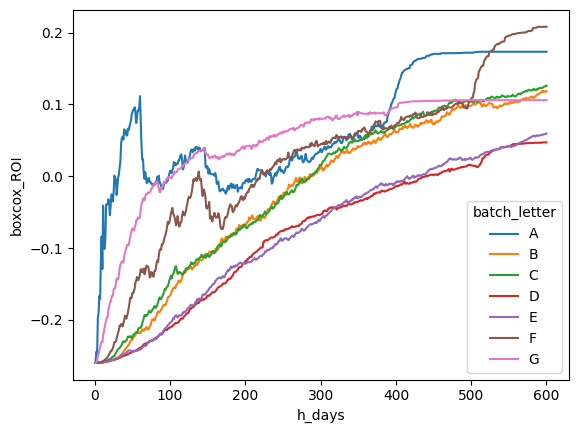

In [108]:
from scipy.stats import boxcox

cohort_features["boxcox_ROI"], maxlog = boxcox(cohort_features["ROI"] + 1.1)
ax = sns.lineplot(data=cohort_features, x="h_days", y="boxcox_ROI", hue="batch_letter")

In [ ]:
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

trend_model = make_pipeline(
    preprocessor,
    LinearRegression()
)

y_train = cohort_features.loc[train_mask, "boxcox_ROI"].copy()

trend_model.fit(X_train, y_train)
cohort_features["predicted_ROI_boxcox_lr_trend"] = trend_model.predict(cohort_features)

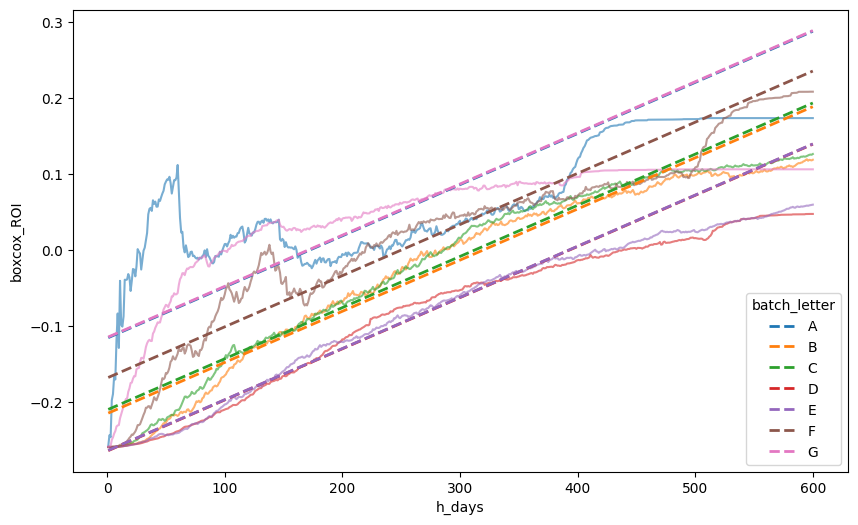

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=cohort_features, x="h_days", y="boxcox_ROI", hue="batch_letter", alpha=0.6, legend=False, ax=ax)
ax = sns.lineplot(data=cohort_features, x='h_days', y="predicted_ROI_boxcox_lr_trend", hue="batch_letter", ls='--', lw=2, ax=ax)

The fitted curves are not perfect, but they are a good approximation of the trend.
Now we can fit the residuals using the LGBM model.

In [111]:
y_train_residuals = y_train - trend_model.predict(X_train)

In [112]:
lgbm_pipeline.fit(X=X_train, y=y_train_residuals)

,steps,"[('columntransformer', ...), ('lgbmregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('h_days', ...), ('batch_letter', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [113]:
from scipy.special import inv_boxcox

cohort_features["boxcox_ROI_residuals_pred"] = lgbm_pipeline.predict(cohort_features)
cohort_features["predicted_ROI_boxcox_lr_lgbm"] = cohort_features["predicted_ROI_boxcox_lr_trend"] + cohort_features["boxcox_ROI_residuals_pred"]
cohort_features["predicted_ROI_lr_lgbm"] = inv_boxcox(cohort_features["predicted_ROI_boxcox_lr_lgbm"], maxlog) - 1.1

c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(-0.8, 0.13927486893616933)

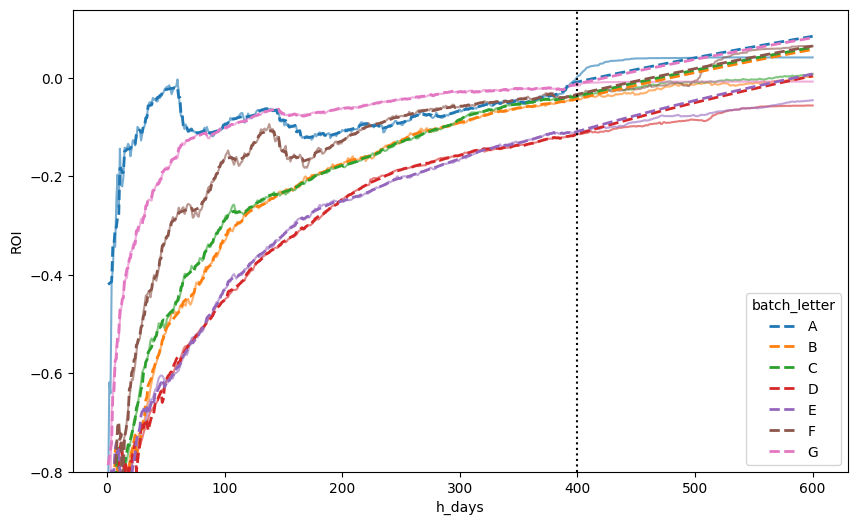

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(data=cohort_features, x="h_days", y="ROI", hue="batch_letter", legend=False, ax=ax, alpha=0.6)
ax = sns.lineplot(data=cohort_features, x="h_days", y="predicted_ROI_lr_lgbm", hue="batch_letter", linestyle="--", ax=ax, lw=2)
ax.axvline(DECISION_TIME_DAYS, color='black', linestyle=':', label='Decision Time')
ax.set_ylim(-0.8, None)



Its seems like the residuals are overfitted, but the trend is well captured.
Lets compute the final metrics.

Displaying the results for all batches. 

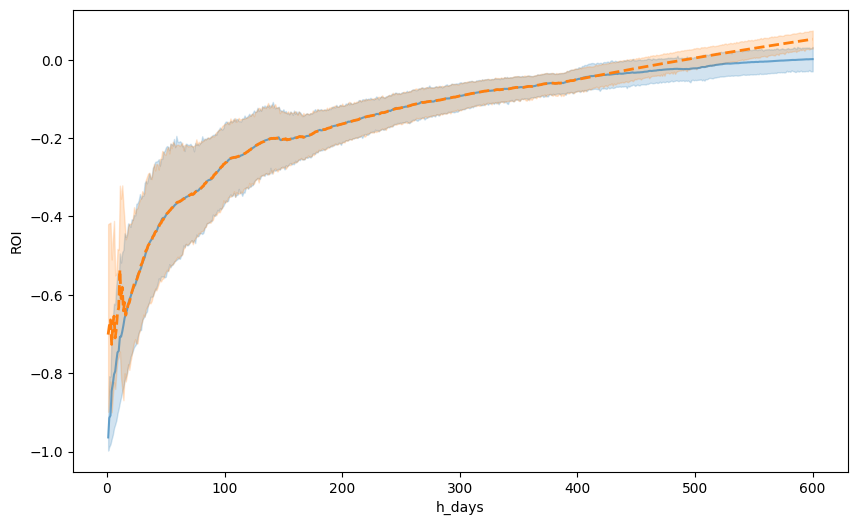

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=cohort_features, x="h_days", y="ROI", legend=False, ax=ax, alpha=0.6)
ax = sns.lineplot(data=cohort_features, x="h_days", y="predicted_ROI_lr_lgbm", linestyle="--", ax=ax, lw=2)

The graph shows that the trend is well captured in fact.

In [116]:
# Applying the full transformation in test variables to ensure that I am not cheating

trend_test = trend_model.predict(X_test) # Trend in boxcox space
residuals_test = boxcox(y_test + 1.1, lmbda=maxlog) - trend_test # Residuals in boxcox space
residuals_pred_test = lgbm_pipeline.predict(X_test)
y_test_pred_final = trend_test + residuals_pred_test # Final prediction in boxcox space
y_test_pred_final = inv_boxcox(y_test_pred_final, maxlog) - 1.1 # Final prediction in original space

mse, r2 = mean_squared_error(y_test, y_test_pred_final), r2_score(y_test, y_test_pred_final)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

Test MSE: 0.0011
Test R²: 0.4524


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


We got reasonable R2 score, which is a good sign. The MSE is also better than the previous model.

# Using the Hybrid Model from src.models

Now let's use the cleaned up version of our hybrid model from the models package.

In [122]:
from src.models import train_hybrid_model, make_predictions_with_uncertainty
from src.models.visualization import plot_predictions_with_uncertainty, plot_uncertainty_analysis

# Train the hybrid model using the cleaned up version
lgbm_params = {
    'random_state': 42,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 4,
    'num_leaves': 15,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1
}

hybrid_model = train_hybrid_model(X_train, y_train, lgbm_params)

# Make predictions
predictions = hybrid_model.predict(X_test)

# Calculate metrics
mse_hybrid = mean_squared_error(y_test, predictions)
r2_hybrid = r2_score(y_test, predictions)

print(f"Hybrid Model Test MSE: {mse_hybrid:.4f}")
print(f"Hybrid Model Test R²: {r2_hybrid:.4f}")

# Compare with previous results
print(f"Previous Model Test MSE: {mse:.4f}")
print(f"Previous Model Test R²: {r2:.4f}")
print(f"Improvement in MSE: {((mse - mse_hybrid) / mse * 100):.2f}%")

Hybrid Model Test MSE: 0.0152
Hybrid Model Test R²: -6.5797
Previous Model Test MSE: 0.0011
Previous Model Test R²: 0.4524
Improvement in MSE: -1284.08%


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [123]:
# Make predictions with uncertainty quantification using bootstrap
print("Calculating uncertainty estimates using bootstrap sampling...")

predictions_with_uncertainty, uncertainty_results, summary_stats = make_predictions_with_uncertainty(
    hybrid_model, X_train, y_train, X_test, 
    n_bootstrap=50,  # Use 50 bootstrap samples for faster execution
    confidence_level=0.95,
    random_state=42
)

# Evaluate with uncertainty
evaluation_metrics = hybrid_model.evaluate(X_test, y_test, uncertainty_results)

print("\nUncertainty Analysis Results:")
print(f"Mean prediction std: {summary_stats['mean_prediction_std']:.4f}")
print(f"Max prediction std: {summary_stats['max_prediction_std']:.4f}")
print(f"Min prediction std: {summary_stats['min_prediction_std']:.4f}")
print(f"95% CI coverage: {evaluation_metrics['ci_coverage']:.2%}")
print(f"Mean CI width: {summary_stats['mean_ci_width']:.4f}")

# Example predictions with uncertainty intervals
print(f"\nExample Predictions with Uncertainty (first 5 test samples):")
for i in range(min(5, len(X_test))):
    h_days = X_test['h_days'].iloc[i]
    actual = y_test.iloc[i]
    pred_mean = uncertainty_results['mean'][i]
    pred_std = uncertainty_results['std'][i]
    lower_ci = uncertainty_results['lower_ci'][i]
    upper_ci = uncertainty_results['upper_ci'][i]
    
    print(f"h_days={h_days:.0f}: {pred_mean:.3f} ± {pred_std:.3f} "
          f"[{lower_ci:.3f}, {upper_ci:.3f}] (actual: {actual:.3f})")

Calculating uncertainty estimates using bootstrap sampling...


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have v


Uncertainty Analysis Results:
Mean prediction std: 0.0017
Max prediction std: 0.0044
Min prediction std: 0.0010
95% CI coverage: 0.00%
Mean CI width: 0.0059

Example Predictions with Uncertainty (first 5 test samples):
h_days=401: 0.094 ± 0.004 [0.085, 0.101] (actual: 0.005)
h_days=402: 0.094 ± 0.004 [0.086, 0.102] (actual: 0.005)
h_days=403: 0.094 ± 0.004 [0.086, 0.102] (actual: 0.009)
h_days=404: 0.095 ± 0.004 [0.087, 0.103] (actual: 0.011)
h_days=405: 0.095 ± 0.004 [0.087, 0.103] (actual: 0.014)


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


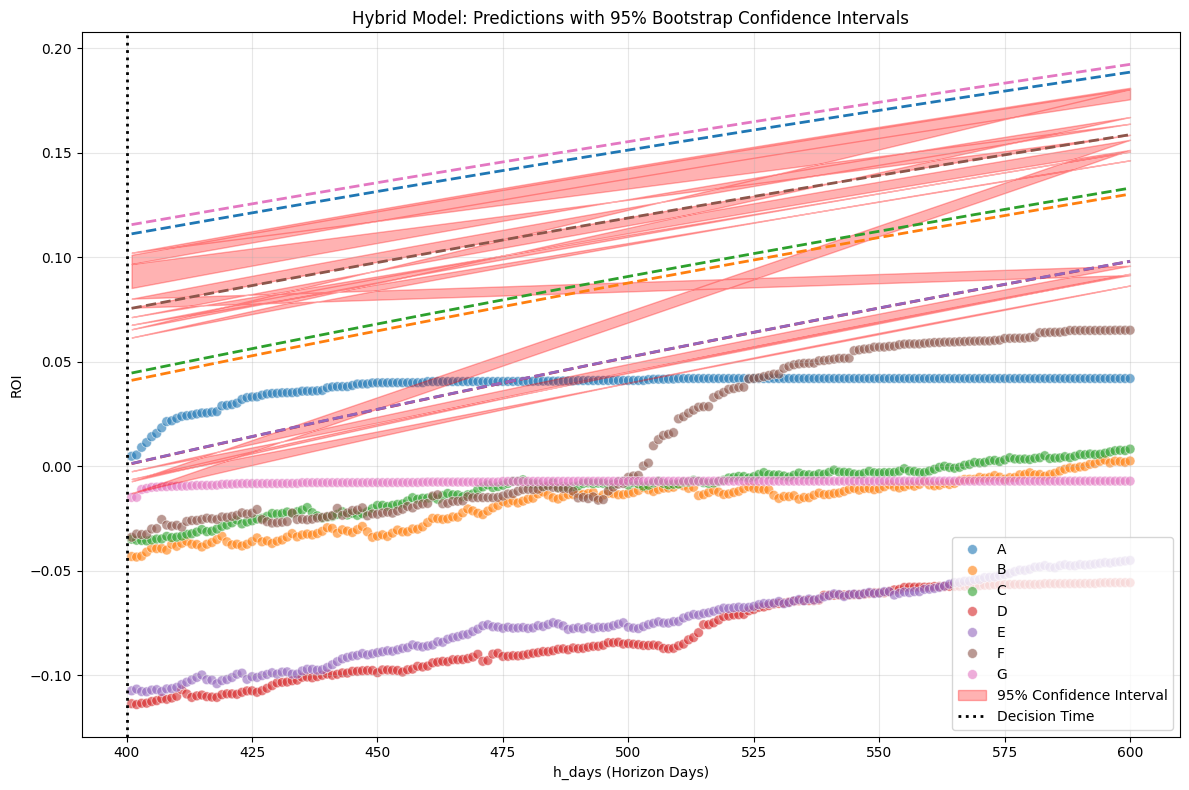

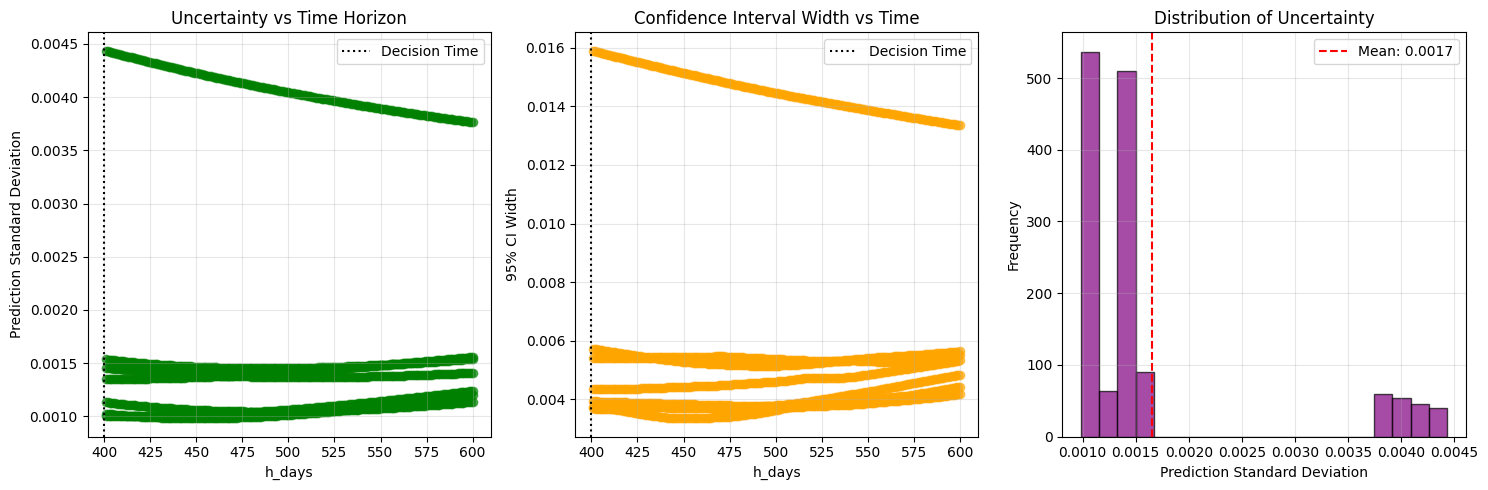

In [125]:
# Visualize predictions with uncertainty
fig = plot_predictions_with_uncertainty(
    X_test, y_test, predictions, uncertainty_results, 
    DECISION_TIME_DAYS, 
    title="Hybrid Model: Predictions with 95% Bootstrap Confidence Intervals"
)
plt.show()

# Show uncertainty analysis
fig2 = plot_uncertainty_analysis(X_test, uncertainty_results, DECISION_TIME_DAYS)
plt.show()